In [17]:
import numpy as np
import pandas as pd
import json

def read_json_to_df(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Read each file into a separate DataFrame
df_train = read_json_to_df('E:/Desktop/Text/Task2/train.json')
df_test = read_json_to_df('E:/Desktop/Text/Task2/test.json')
df_valid = read_json_to_df('E:/Desktop/Text/Task2/valid.json')


# Convert numbers to strings (processing tokens and tags)
df_train['tokens'] = df_train['tokens'].apply(lambda x: [str(i) for i in x])
df_train['tags'] = df_train['tags'].apply(lambda x: [str(i) for i in x])
df_valid['tokens'] = df_valid['tokens'].apply(lambda x: [str(i) for i in x])
df_valid['tags'] = df_valid['tags'].apply(lambda x: [str(i) for i in x])
df_test['tokens'] = df_test['tokens'].apply(lambda x: [str(i) for i in x])
df_test['tags'] = df_test['tags'].apply(lambda x: [str(i) for i in x])


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Extract tokens and tags
train_sentences = df_train['tokens'].tolist()
train_tags = df_train['tags'].tolist()
valid_sentences = df_valid['tokens'].tolist()
valid_tags = df_valid['tags'].tolist()
test_sentences = df_test['tokens'].tolist()
test_tags = df_test['tags'].tolist()

# Create tokenizer
tokenizer = Tokenizer(num_words=5120, oov_token='UNK')
tokenizer.fit_on_texts(train_sentences)

# Convert text to sequences
train_seq = tokenizer.texts_to_sequences(train_sentences)
valid_seq = tokenizer.texts_to_sequences(valid_sentences)
test_seq = tokenizer.texts_to_sequences(test_sentences)


# Pad sequences
max_len = 46
train_seq_padded = pad_sequences(train_seq, maxlen=max_len, padding='post')
valid_seq_padded = pad_sequences(valid_seq, maxlen=max_len, padding='post')
test_seq_padded = pad_sequences(test_seq, maxlen=max_len, padding='post')


# Pad tag sequences
train_tag_seq_padded = pad_sequences(train_tags, maxlen=max_len, padding='post')
valid_tag_seq_padded = pad_sequences(valid_tags, maxlen=max_len, padding='post')
test_tag_seq_padded = pad_sequences(test_tags, maxlen=max_len, padding='post')


# One-hot encode tags
num_tags = 5
train_tags_encoded = to_categorical(train_tag_seq_padded, num_classes=num_tags)
valid_tags_encoded = to_categorical(valid_tag_seq_padded, num_classes=num_tags)
test_tags_encoded = to_categorical(test_tag_seq_padded, num_classes=num_tags)


In [19]:
# Build a BiLSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=5120, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Configure early stopping policy
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Train and evaluate the model
history = model.fit(train_seq_padded, train_tags_encoded, batch_size=32, epochs=10, validation_data=(valid_seq_padded, valid_tags_encoded), callbacks=[early_stopping])



# Evaluate the model
y_pred = model.predict(test_seq_padded)
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(test_tags_encoded, axis=-1)



# Check for mislabeled sentences
def find_mislabelled_sentences(y_true, y_pred, sentences, id2label):
    mislabelled = []
    for true_seq, pred_seq, sent in zip(y_true, y_pred, sentences):
        for idx, (true_tag, pred_tag) in enumerate(zip(true_seq, pred_seq)):
            if true_tag != pred_tag:
                mislabelled.append((sent, idx, id2label[true_tag], id2label[pred_tag]))
                break  
    return mislabelled

# Function to extract entities from the sequence
def get_entities(seq, id2label):
    entities = []
    current_entity = None
    for idx, tag in enumerate(seq):
        if tag == 0:  # "O" tag, end any current entity
            if current_entity:
                entities.append(current_entity)
                current_entity = None
        else:  # "B-" or "I-" tag
            label = id2label[tag]
            if label.startswith("B-"):
                if current_entity:
                    entities.append(current_entity)
                current_entity = [label[2:], idx, idx]
            elif label.startswith("I-") and current_entity and current_entity[0] == label[2:]:
                current_entity[2] = idx
            else:  # Found an "I-" without a preceding "B-"
                if current_entity:
                    entities.append(current_entity)
                current_entity = None
    if current_entity:
        entities.append(current_entity)
    return entities

# ID to label mapping
id2label = {0: "O", 1: "B-Chemical", 2: "B-Disease", 3: "I-Disease", 4: "I-Chemical"}


# Get mislabeled sentences
mislabelled_sentences = find_mislabelled_sentences(y_true_labels, y_pred_labels, test_sentences, id2label)

# Display the top five mislabeled sentences
print("Mislabelled sentences:")
for sent, idx, true_tag, pred_tag in mislabelled_sentences[:5]:
    print(f"Sentence: {' '.join(sent)}")
    print(f"Index: {idx}, True tag: {true_tag}, Predicted tag: {pred_tag}")
    print()


# Get true and predicted entities
y_true_entities = [get_entities(seq, id2label) for seq in y_true_labels]
y_pred_entities = [get_entities(seq, id2label) for seq in y_pred_labels]
print("y_true_entities first five outputs:")
print(y_true_entities[:5])

print("\ny_pred_entities first five outputs:")
print(y_pred_entities[:5])


# Calculate metrics
def entity_metrics(true_entities, pred_entities):
    tp = 0
    fp = 0
    fn = 0
    for true, pred in zip(true_entities, pred_entities):
        true_set = set(tuple(e) for e in true)
        pred_set = set(tuple(e) for e in pred)
        tp += len(true_set & pred_set)
        fp += len(pred_set - true_set)
        fn += len(true_set - pred_set)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

precision, recall, f1 = entity_metrics(y_true_entities, y_pred_entities)

print(f"Entity Precision: {precision:.2f}")
print(f"Entity Recall: {recall:.2f}")
print(f"Entity F1 Score: {f1:.2f}")

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9330 - loss: 0.3977 - val_accuracy: 0.9538 - val_loss: 0.1270
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9624 - loss: 0.1062 - val_accuracy: 0.9715 - val_loss: 0.0900
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9818 - loss: 0.0603 - val_accuracy: 0.9754 - val_loss: 0.0761
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9873 - loss: 0.0417 - val_accuracy: 0.9774 - val_loss: 0.0701
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9901 - loss: 0.0311 - val_accuracy: 0.9767 - val_loss: 0.0742
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9924 - loss: 0.0239 - val_accuracy: 0.9779 - val_loss: 0.0749
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9941 - loss: 0.0186 - val_accuracy: 0.9773 - val_loss: 0.0795
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
184/184 ━━━━━

In [20]:
# # View the number of labels
# import numpy as np
# import pandas as pd
# import json
# from collections import Counter

# def read_json_to_df(file_path):
#     data = []
#     with open(file_path, 'r') as file:
#         for line in file:
#             data.append(json.loads(line))
#     return pd.DataFrame(data)

# def count_labels(df):
#     all_tags = [str(tag) for tags in df['tags'] for tag in tags]
#     label_count = Counter(all_tags)
#     result = {str(label): label_count.get(str(label), 0) for label in range(5)}
#     return result

# # Read each file into a separate DataFrame
# df_train = read_json_to_df('E:/Desktop/Text/Task2/train.json')
# df_test = read_json_to_df('E:/Desktop/Text/Task2/test.json')
# df_valid = read_json_to_df('E:/Desktop/Text/Task2/valid.json')

# # Count labels in each DataFrame
# train_label_count = count_labels(df_train)
# test_label_count = count_labels(df_test)
# valid_label_count = count_labels(df_valid)

# print(f"Train label count: {train_label_count}")
# print(f"Test label count: {test_label_count}")
# print(f"Valid label count: {valid_label_count}")


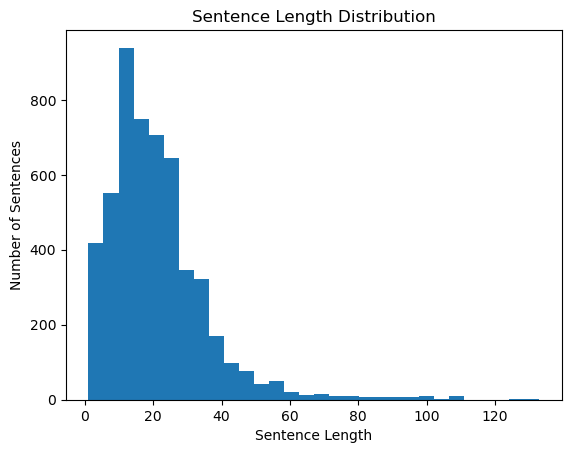

Mean Length: 20.910864575363426
Median Length: 18.0
95th Percentile: 46.0
Unique words: 9926
Vocabulary size to cover 95% of words: 5120


In [3]:
# import numpy as np
# import pandas as pd
# from collections import Counter
# import matplotlib.pyplot as plt
# import json

# def read_json_to_df(file_path):
#     data = []
#     with open(file_path, 'r') as file:
#         for line in file:
#             data.append(json.loads(line))
#     return pd.DataFrame(data)

# # Read each file into a separate DataFrame
# df_train = read_json_to_df('E:/Desktop/Text/Task2/train.json')

# def analyze_data(df):
#     # Calculate the length of each sentence
#     df['sentence_length'] = df['tokens'].apply(len)

#     # Count the occurrences of all words
#     word_counts = Counter(word for tokens_list in df['tokens'] for word in tokens_list)

#     # Plot the distribution of sentence lengths
#     plt.hist(df['sentence_length'], bins=30)
#     plt.title('Sentence Length Distribution')
#     plt.xlabel('Sentence Length')
#     plt.ylabel('Number of Sentences')
#     plt.show()

#     # Print descriptive statistics for sentence lengths
#     mean_length = df['sentence_length'].mean()
#     median_length = df['sentence_length'].median()
#     percentile_95 = np.percentile(df['sentence_length'], 95)

#     print("Mean Length:", mean_length)
#     print("Median Length:", median_length)
#     print("95th Percentile:", percentile_95)

#     # Print the number of unique words
#     unique_words = len(word_counts)
#     print("Unique words:", unique_words)

#     # Set vocabulary size based on word frequency
#     total_words = sum(word_counts.values())
#     cumulative = 0
#     sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

#     max_vocab_size = 0
#     for word, freq in sorted_words:
#         cumulative += freq
#         if cumulative / total_words > 0.95:
#             max_vocab_size = sorted_words.index((word, freq)) + 1
#             break

#     print("Vocabulary size to cover 95% of words:", max_vocab_size)

# # Analyze the training data
# analyze_data(df_train)
